In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
data_dir = '/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset'
CLASS_LIST = ['Violence','NonViolence']
seed = 42
img_height, img_width = 120, 120
batch_size = 8
SEQUENCE_LENGTH = 16

In [3]:
def extract_frames(video_path):

    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LENGTH,1)

    for i in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)

        ret,frame = video_reader.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame,(img_height,img_width))

        normalized_frame = resized_frame / 255.0

        frames.append(normalized_frame)

    video_reader.release()

    return frames

def create_dataset(max_vid_per_class = 600):

    features = []
    labels = []
    #video_files_paths = []


    for class_index,class_name in enumerate(CLASS_LIST):

        print(f"Extracting Data of Class:{class_name}")

        files_list = os.listdir(os.path.join(data_dir,class_name))

        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break

            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
               #video_files_paths.append(video_path)
                count += 1

            #print(f"Extraction of {filename} into frames. Completed {count}/{max_vid_per_class}")

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [4]:
features,labels = create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0x59aa07613b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x59aa07613b80] error while decoding MB 98 31
[h264 @ 0x59aa07613b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x59aa07613b80] error while decoding MB 98 31
[h264 @ 0x59aa07613b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x59aa07613b80] error while decoding MB 98 31
[h264 @ 0x59aa07613b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x59aa07613b80] error while decoding MB 98 31


In [5]:
# Save the features
np.save('features.npy', features)

# Save the labels
np.save('labels.npy', labels)

In [6]:
features_train,features_val,labels_train,labels_val = train_test_split(features,labels,
                                                                        test_size=0.2,
                                                                        random_state=seed)

In [7]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential()

# Use an Input layer to specify the input shape
model.add(Input(shape=(16, 120, 120, 3)))

# 1st Conv3D Layer with increased filters
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 2nd Conv3D Layer with increased filters
model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 3rd Conv3D Layer with increased filters
model.add(Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# 4th Conv3D Layer with increased filters
model.add(Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output from the Conv3D layers
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())  # Add BatchNormalization after Dense layer
model.add(Dropout(0.4))  # Dropout for regularization

# 2nd Fully Connected Layer (newly added)
model.add(Dense(units=256, activation='relu'))  # New dense layer
model.add(BatchNormalization())  # Add BatchNormalization after the new dense layer
model.add(Dropout(0.4))  # Regularization for the new layer

# Output Layer for Binary Classification
model.add(Dense(units=2, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 120, 120,   │         5,248 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 120, 120,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 60, 60, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 60, 60, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 60, 60, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 30, 30, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 30, 30, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 30, 30, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 15, 15, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 2, 15, 15, 512) │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 15, 15, 512) │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 1, 7, 7, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,635,330 (67.27 MB)

 Trainable params: 17,631,874 (67.26 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [9]:
# Reduce learning rate when validation accuracy plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# Define the ModelCheckpoint callback
checkpoint1 = ModelCheckpoint(
    filepath='best3dcnn_model.weights.h5',   # Path to save the model
    monitor='val_accuracy',     # Monitor validation accuracy
    save_best_only=True,        # Save only the best model
    save_weights_only=True,
    mode='max',                 # 'max' because we want to maximize accuracy
    verbose=1                   # Print a message when saving the model
)

checkpoint2 = ModelCheckpoint(
    filepath='best3dcnn_model.keras',   # Path to save the model
    monitor='val_accuracy',     # Monitor validation accuracy
    save_best_only=True,        # Save only the best model
    save_weights_only=False,
    mode='max',                 # 'max' because we want to maximize accuracy
    verbose=1                   # Print a message when saving the model
)


early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=15,             # Stop after 3 epochs of no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best validation loss
    mode='min'              # 'min' because we want to minimize validation loss
)

In [11]:
history = model.fit(features_train, ohc_labels_train, epochs=40, batch_size=8, validation_data=(features_val, ohc_labels_val), callbacks=[early_stopping, checkpoint1, checkpoint2, reduce_lr])

Epoch 1/40


I0000 00:00:1729795053.913968    4934 service.cc:145] XLA service 0x7e6948007e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729795053.914795    4934 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729795053.914809    4934 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729795070.485427    4934 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6066 - loss: 0.8975
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to best3dcnn_model.weights.h5

Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to best3dcnn_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.6067 - loss: 0.8970 - val_accuracy: 0.4917 - val_loss: 1.2730 - learning_rate: 0.0010
Epoch 2/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6973 - loss: 0.7099
Epoch 2: val_accuracy did not improve from 0.49167

Epoch 2: val_accuracy did not improve from 0.49167
120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 242ms/step - accuracy: 0.6974 - loss: 0.7095 - val_accuracy: 0.4917 - val_loss: 3.4939 - learning_rate: 0.0010
Epoch 3/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6977 - loss: 0.6699
Epoch 3: val_accuracy improved from 0.49167 to 0.51250, saving model to best3dcnn_model.weights.h5

Epoch 3: val_accuracy improved from 0.49167 to 0.51250, saving model

In [12]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

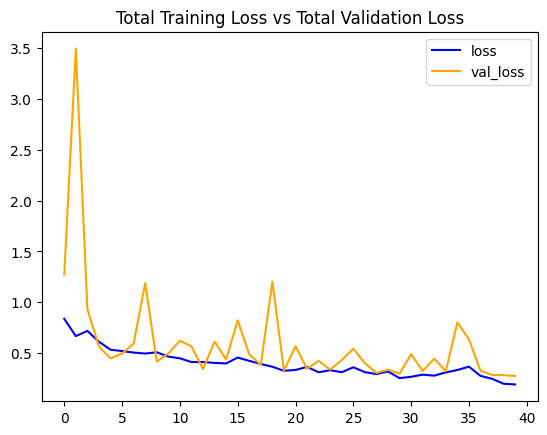

In [13]:
plot_metric(history, 'loss', 'val_loss', 'Total Training Loss vs Total Validation Loss')

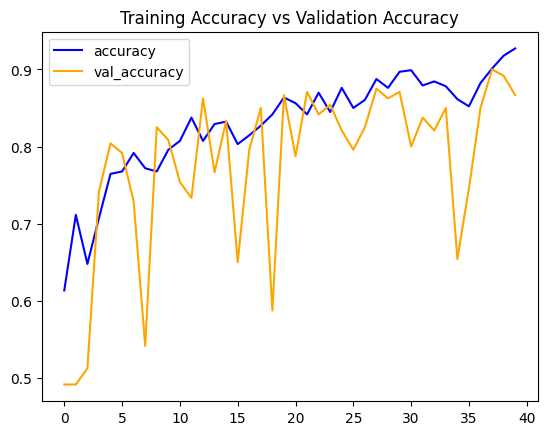

In [14]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Training Accuracy vs Validation Accuracy')